# Data Exercise

The task it to forecast Y given X and Z. The problem also states that the conditional expectation of Y given X is linear, meaning: $$ E[\vec{Y}| \mathbf{X}] = \mathbf{X} \cdot \vec{\beta} 
$$ 
or equivalently (ignoring the influence of Z) $$ \vec{Y} = \mathbf{X} \cdot \vec{\beta} + \vec{\epsilon}$$ where $ \vec{ \epsilon} $ is a vector of noise

In [246]:
# various imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import normaltest # D’Agostino and Pearson’s Test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from xgboost import XGBRegressor
import tensorflow.keras as keras


# Step 1 -	Examine and present the main characteristics of the data

In [247]:
## import the data
X = pd.read_csv('X.csv', index_col=0, names=['X0','X1','X2','X3'],skiprows=[0]) # looks like the first column is just the index
Y = pd.read_csv('Y.csv', index_col=0, names=['Y0'],skiprows=[0])
Z = pd.read_csv('Z.csv', index_col=0, names=['Z0','Z1'],skiprows=[0])

print('Looking at X....')
print(X.describe())
print('------------------------------')
print('Looking at Y....')
print(Y.describe())
print('------------------------------')
print('Looking at Z....')
print(Z.describe())

Looking at X....
                 X0           X1           X2           X3
count   9998.000000  9997.000000  9989.000000  9999.000000
mean       1.000220     0.093774     0.119424     0.224848
std      100.053353     4.500255    10.020649    59.493918
min       -8.782482   -19.873700    -2.792640 -3001.334527
25%       -1.535020    -2.987551    -0.527712    -0.854265
50%       -0.022499     0.067728     0.033690     0.016713
75%        1.545641     3.175547     0.557946     0.868895
max    10001.660383    15.579372   998.329754  5134.656375
------------------------------
Looking at Y....
                 Y0
count  10000.000000
mean       0.071309
std        6.828527
min      -29.504656
25%       -4.684751
50%        0.077482
75%        4.764417
max       26.526210
------------------------------
Looking at Z....
                 Z0            Z1
count  10000.000000  10000.000000
mean       0.508268      0.508695
std        0.587712      0.325677
min       -1.509356     -0.655735
25%   

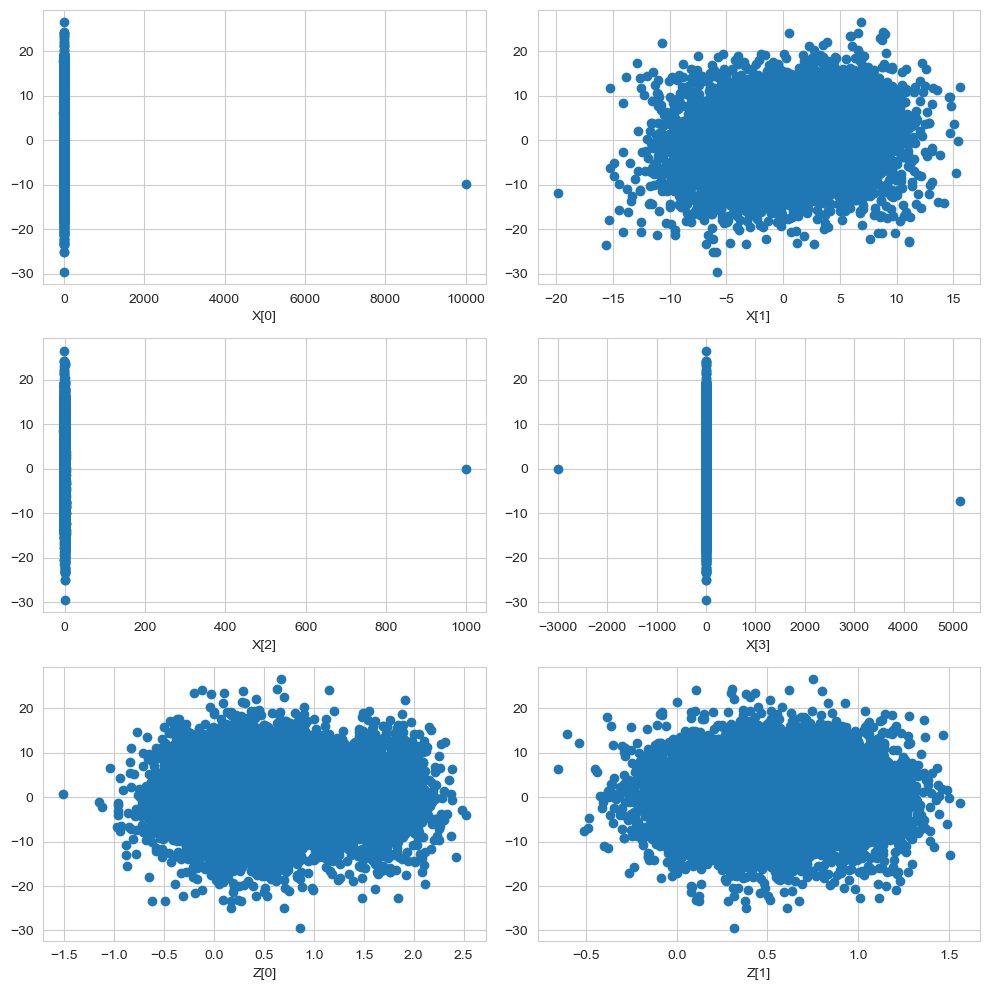

It looks like there are some outliers in the dataset. More specifically, X[0] and X[2] have 1 point that is too far to the right, X[3] has 1 point that is too far to the left and 1 that is too far to the right. Z looks ok.


In [248]:
# look at Y against the features in X
fig, axs = plt.subplots(3, 2, ) # create the figure

#plot the Xs
for i in range(2):
    for j in range(2):
        axs[i,j].scatter(X[f'X{i*2+j}'],Y['Y0']) 
        axs[i,j].set_xlabel(f'X[{i*2+j}]')
# plot the Zs
for i in range(2):
        axs[2,i].scatter(Z[f'Z{i}'],Y['Y0']) 
        axs[2,i].set_xlabel(f'Z[{i}]')

plt.tight_layout()
plt.show()
print('It looks like there are some outliers in the dataset. More specifically, X[0] and X[2] have 1 point that is too far to the right, X[3] has 1 point that is too far to the left and 1 that is too far to the right. Z looks ok.')

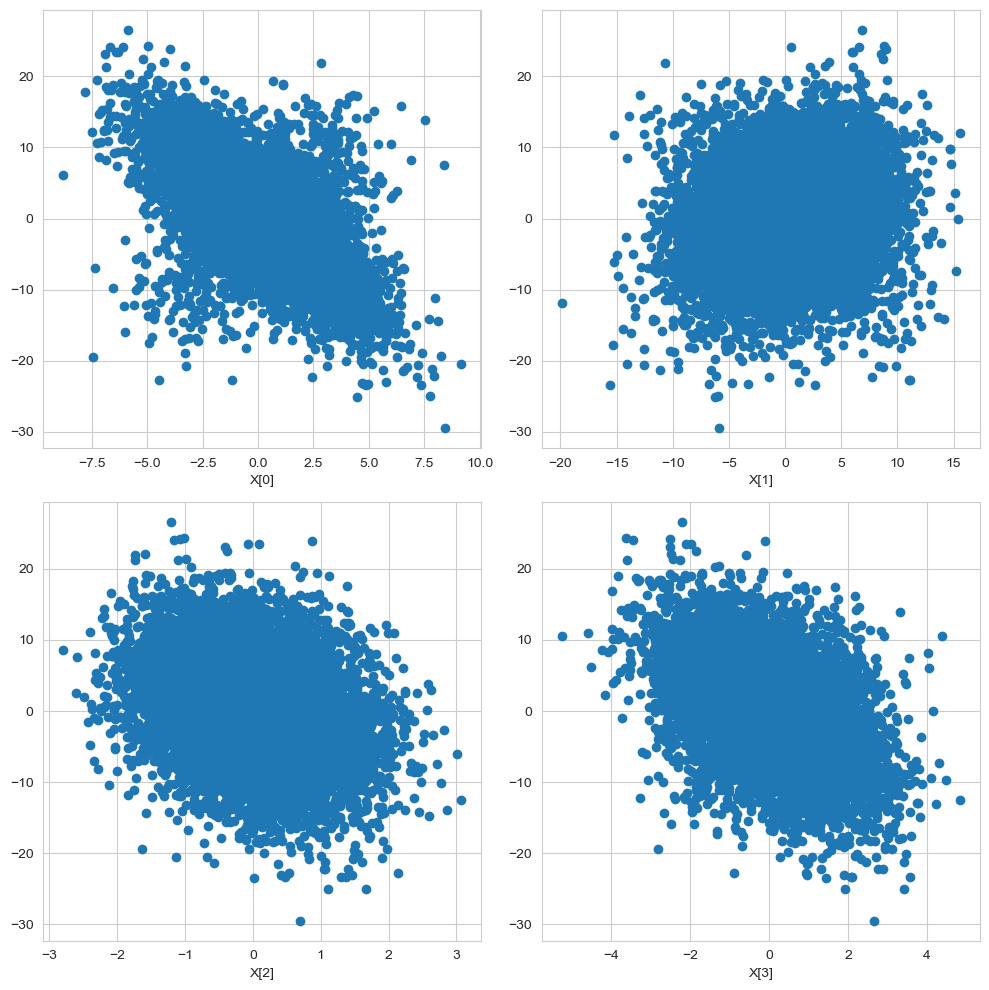

Looks like there is some negative correlation in X[0], X[2] and X[3]. X[1] has modest positive correlations.
The plot for X[0] suggests a more complex relationship than a simple linear behavior, as there may be a weaker positive trend within as if the data models two populations or X[0] potentially interacts with another unmeasured variable or it is nonlinearly related to Y.


In [249]:
# replace the outliers, and look at the data again
X.loc[X['X0']>5000,'X0'] = np.nan
X.loc[X['X2']>600,'X2'] = np.nan
X.loc[X['X3']>4000,'X3'] = np.nan
X.loc[X['X3']<-2000,'X3'] = np.nan

fig, axs = plt.subplots(2, 2, ) # create the figure

for i in range(2):
    for j in range(2):
        axs[i,j].scatter(X[f'X{i*2+j}'],Y['Y0']) 
        axs[i,j].set_xlabel(f'X[{i*2+j}]')
plt.tight_layout()
plt.show()
print('Looks like there is some negative correlation in X[0], X[2] and X[3]. X[1] has modest positive correlations.')
print('The plot for X[0] suggests a more complex relationship than a simple linear behavior, as there may be a weaker positive trend within as if the data models two populations or X[0] potentially interacts with another unmeasured variable or it is nonlinearly related to Y.')

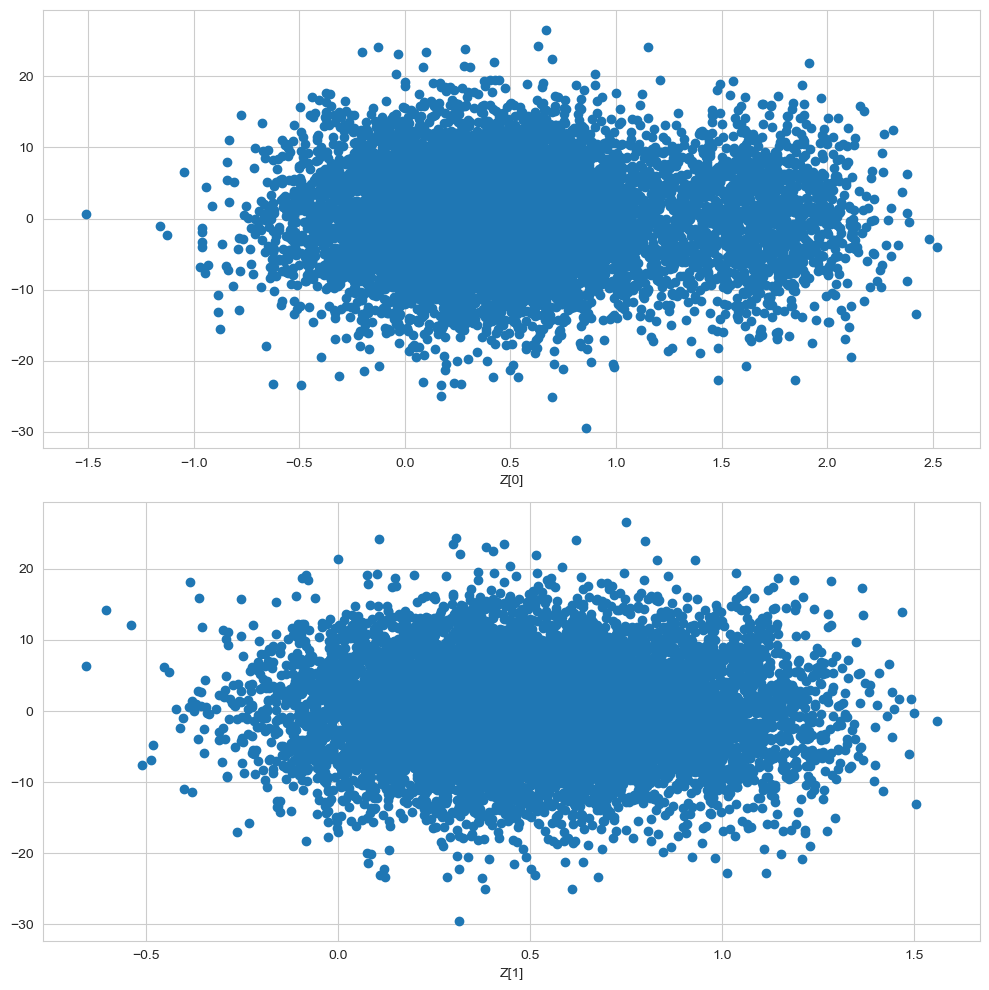

Looks like there is some very weak correlation between Z and Y, hard to say


In [250]:
# now, look at the feature against Z
fig, axs = plt.subplots(2, 1, )

for i in range(2):
        axs[i].scatter(Z[f'Z{i}'],Y['Y0']) 
        axs[i].set_xlabel(f'Z[{i}]')
plt.tight_layout()
plt.show()
print('Looks like there is some very weak correlation between Z and Y, hard to say')

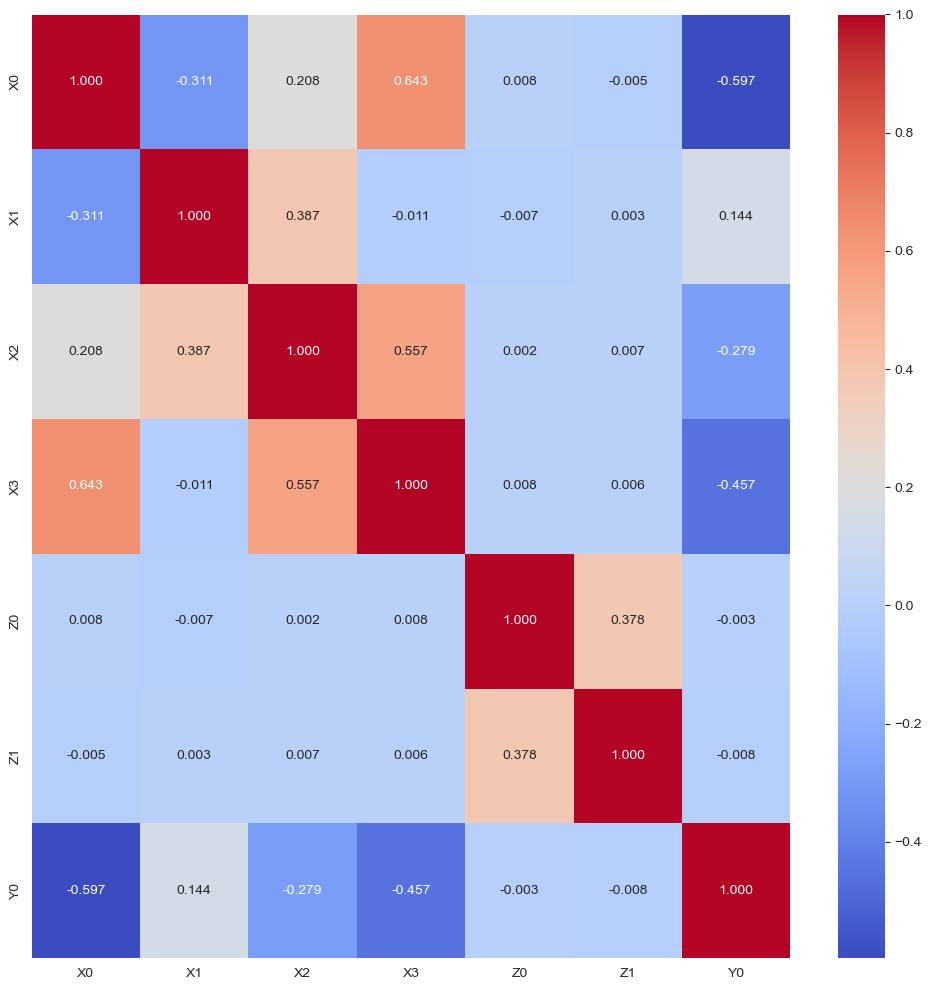

Indeed, the correlation between Z and Y is very weak, while between X and Y is significant.


In [251]:
# take a look at the correlation map between the different features and the target variable.
new_dset = pd.concat([X,Z,Y],axis=1,)

# plot a heatmap of the correlations between columns of the dataset
sns.heatmap(new_dset.corr(), annot=True, cmap='coolwarm',fmt=".3f",
            xticklabels=new_dset.columns,
            yticklabels=new_dset.columns)
plt.tight_layout()
plt.show()
print('Indeed, the correlation between Z and Y is very weak, while between X and Y is significant.')

What about cross terms between Xs and Zs?


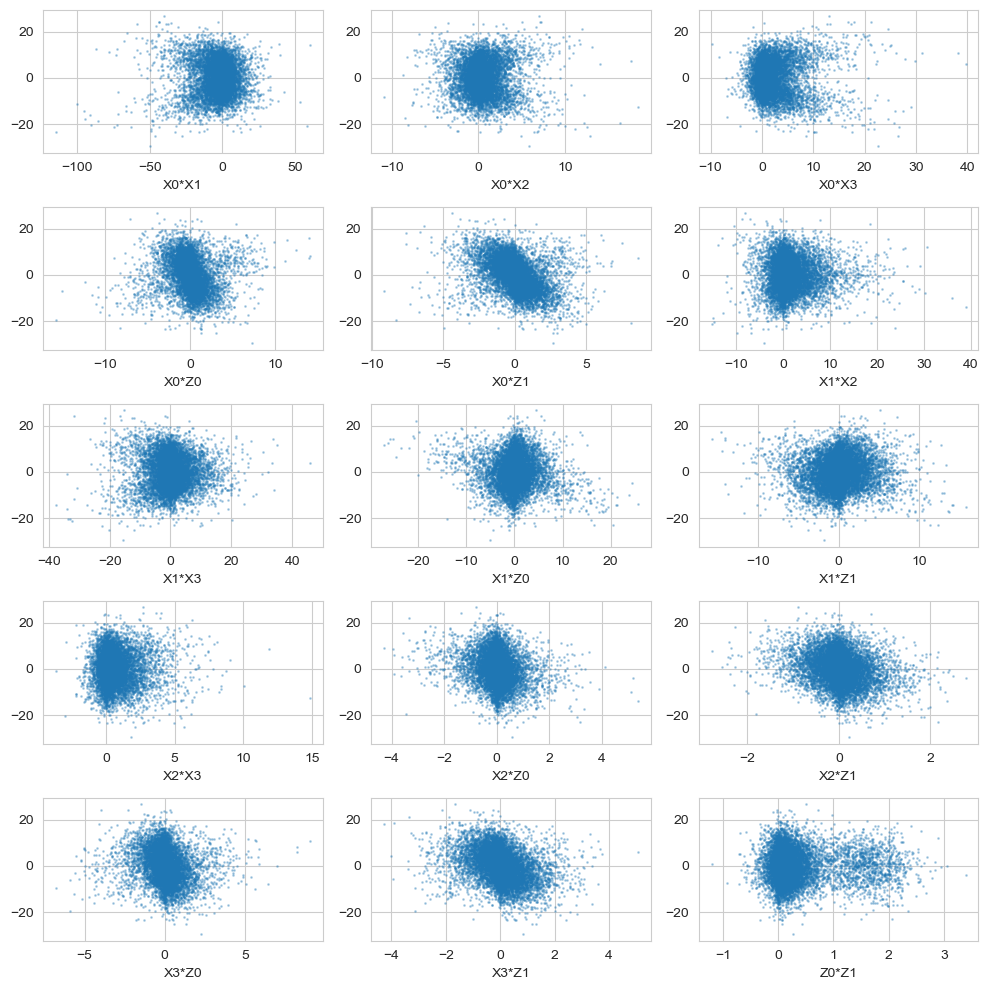

It looks like the cross terms provide additional information (e.g. X0*Z0 or X0*Z1)


In [252]:
print('What about cross terms between Xs and Zs?')
from itertools import combinations
plt.rcParams['figure.figsize'] = [10, 10] # increase size, otherwise this plot is too small 
fig, axs = plt.subplots(5, 3, )
options = ['X0','X1','X2','X3','Z0','Z1'] # possible features available 
combs = list(combinations(options,2)) # create all the combinations of 2 features
for i,comb in enumerate(combs):
    # print(i, i//3,i%3)
    plot_x = new_dset[comb[0]]*new_dset[comb[1]]
    axs[i//3,i%3].scatter(plot_x,new_dset['Y0'],s=1,alpha=0.3) 
    axs[i//3,i%3].set_xlabel(f'{comb[0]}*{comb[1]}')
plt.tight_layout()
plt.show()
print('It looks like the cross terms provide additional information (e.g. X0*Z0 or X0*Z1)')

Now look at the distribution of Y


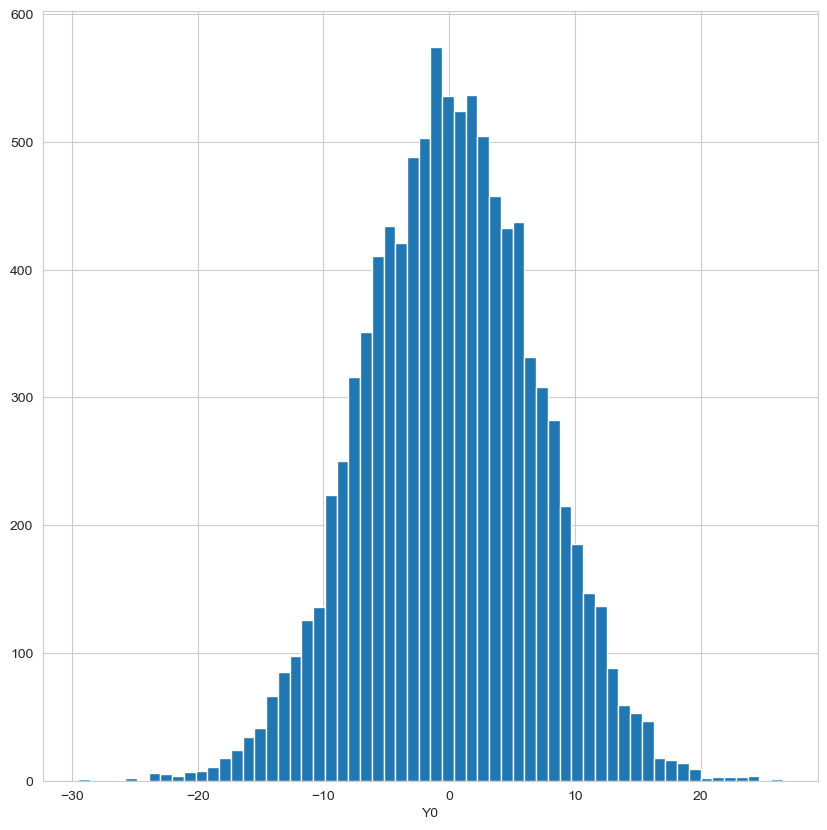

Y looks mostly normally distributed.


In [253]:
print('Now look at the distribution of Y')
plt.hist(new_dset['Y0'],bins=60)
plt.xlabel('Y0')
plt.show()
print('Y looks mostly normally distributed.')

In [255]:
# do some more exploration of the dataset
print(new_dset.describe())
print(new_dset.isnull().sum())
print(f'Looking at the data, it looks like there are not too many nans (12 at most in X2). It may be possible to substitute the nans for the median, or use a more advanced approach (e.g. KNN or Iterative Imputer, which could be promising since the features in X are correlated with one another), but given the small amount of data being lost (~{10/len(new_dset)}), it should be safe to drop the affected rows.)')

                X0           X1           X2           X3            Z0  \
count  9997.000000  9997.000000  9988.000000  9997.000000  10000.000000   
mean     -0.000146     0.093774     0.019483     0.011497      0.508268   
std       2.313331     4.500255     0.800861     1.264495      0.587712   
min      -8.782482   -19.873700    -2.792640    -5.252796     -1.509356   
25%      -1.535537    -2.987551    -0.527748    -0.854153      0.111543   
50%      -0.022762     0.067728     0.033596     0.016713      0.419631   
75%       1.544953     3.175547     0.557808     0.868734      0.777893   
max       9.176625    15.579372     3.074041     4.833374      2.521868   

                 Z1            Y0  
count  10000.000000  10000.000000  
mean       0.508695      0.071309  
std        0.325677      6.828527  
min       -0.655735    -29.504656  
25%        0.281681     -4.684751  
50%        0.496166      0.077482  
75%        0.728490      4.764417  
max        1.561573     26.526210  


In [256]:
# drop nans from the new dataset
new_dset.dropna(inplace=True)
print('Confirm that there are no nans after dropping the affected rows:')
print(new_dset.isnull().sum())
new_dset.describe()

Confirm that there are no nans after dropping the affected rows:
X0    0
X1    0
X2    0
X3    0
Z0    0
Z1    0
Y0    0
dtype: int64


,X0,X1,X2,X3,Z0,Z1,Y0
count,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000
mean,-0.000003,0.096896,0.019551,0.011570,0.508264,0.508719,0.074859
std,2.313791,4.500247,0.800972,1.265022,0.587551,0.325622,6.830385
min,-8.782482,-19.873700,-2.792640,-5.252796,-1.509356,-0.655735,-29.504656
25%,-1.537521,-2.982326,-0.527699,-0.854669,0.111685,0.281441,-4.682883
50%,-0.023437,0.071129,0.033502,0.017721,0.419656,0.496243,0.086056
75%,1.547138,3.177449,0.557983,0.869539,0.777637,0.728467,4.771111
max,9.176625,15.579372,3.074041,4.833374,2.521868,1.561573,26.526210



#### Let's now look at the distribution of the data

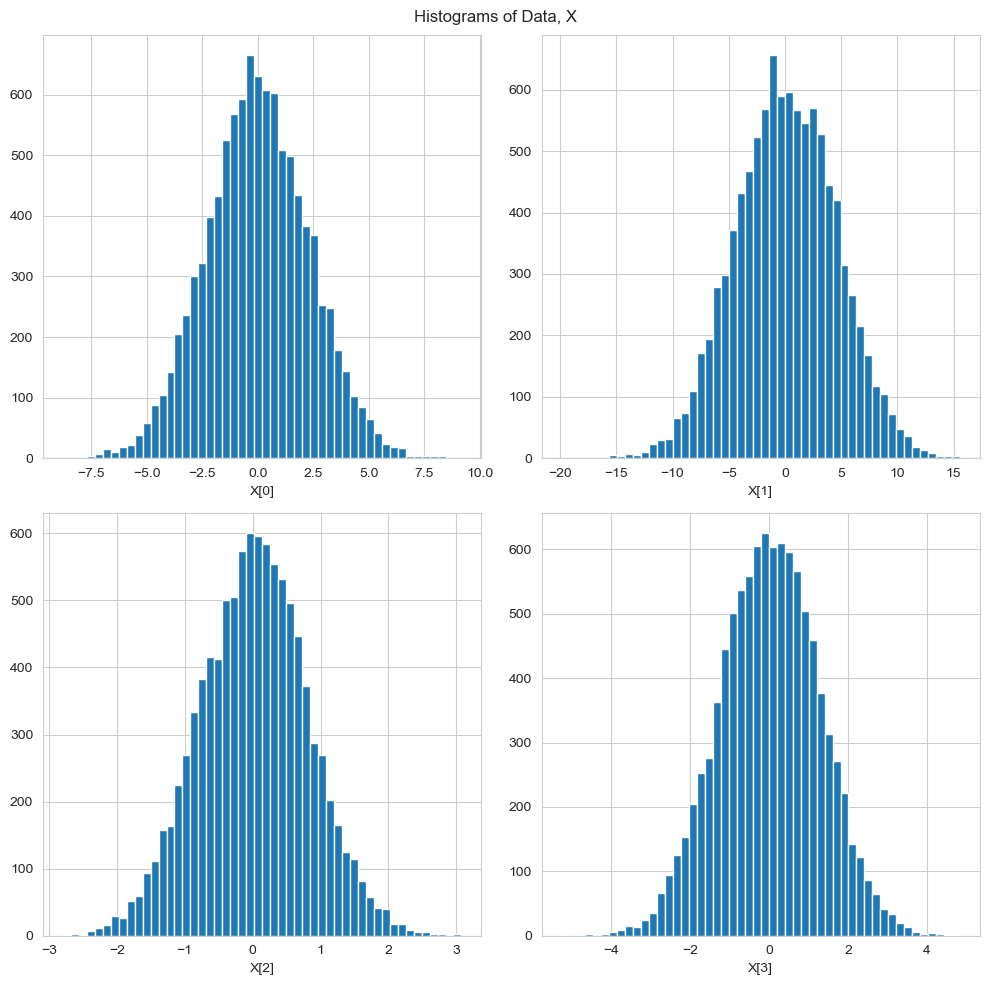

Data looks fairly normally distributed.


In [257]:
fig, axs = plt.subplots(2, 2, )

fig.suptitle('Histograms of Data, X')
for i in range(2):
    for j in range(2):
        axs[i,j].hist(new_dset[f'X{i*2+j}'],bins=50) 
        axs[i,j].set_xlabel(f'X[{i*2+j}]')

plt.tight_layout()
plt.show()
print('Data looks fairly normally distributed.')

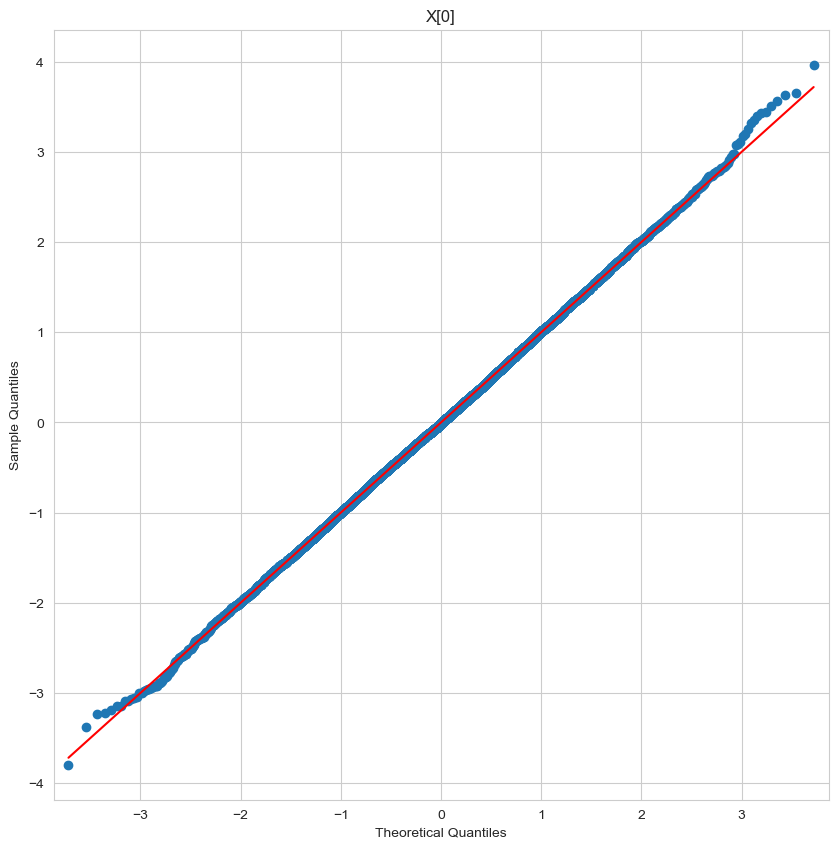

The data is normally distributed.
-------------------------------------


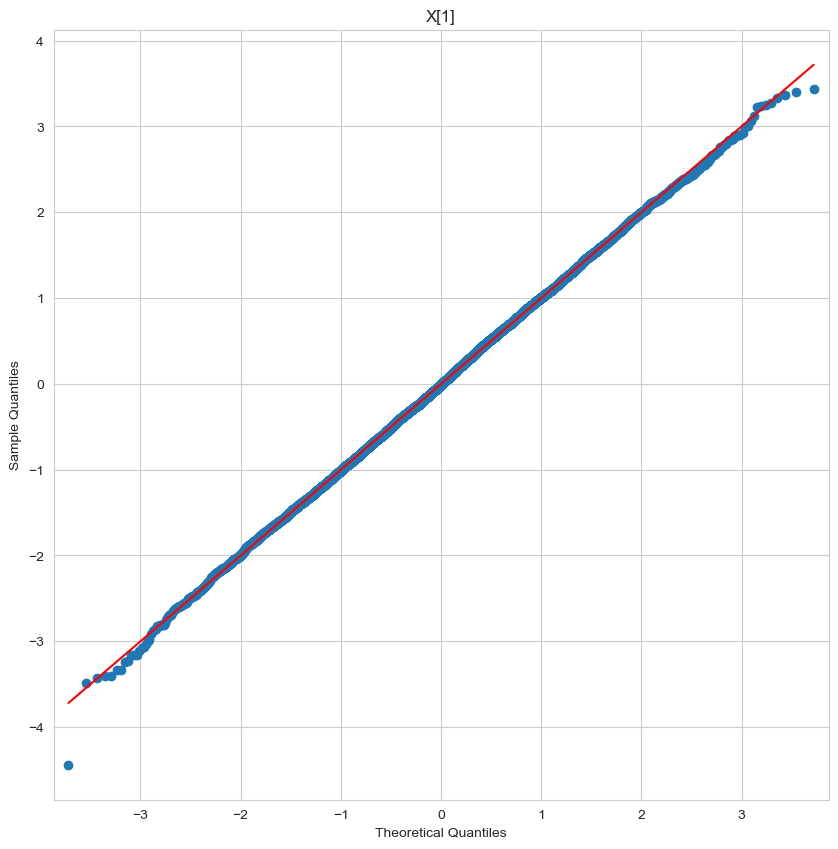

The data is normally distributed.
-------------------------------------


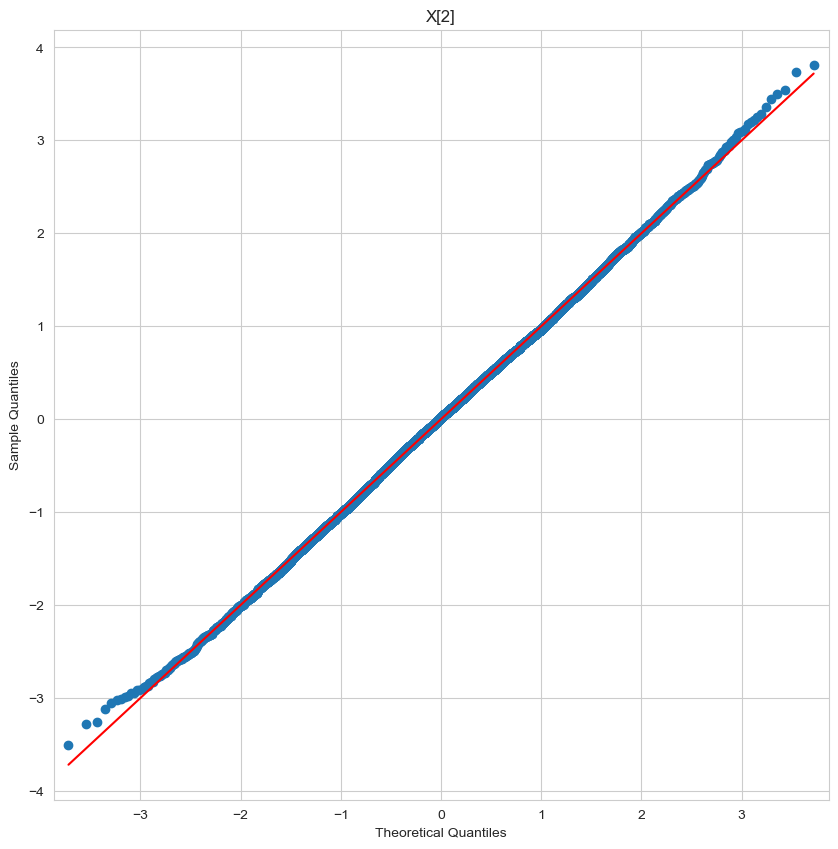

The data is normally distributed.
-------------------------------------


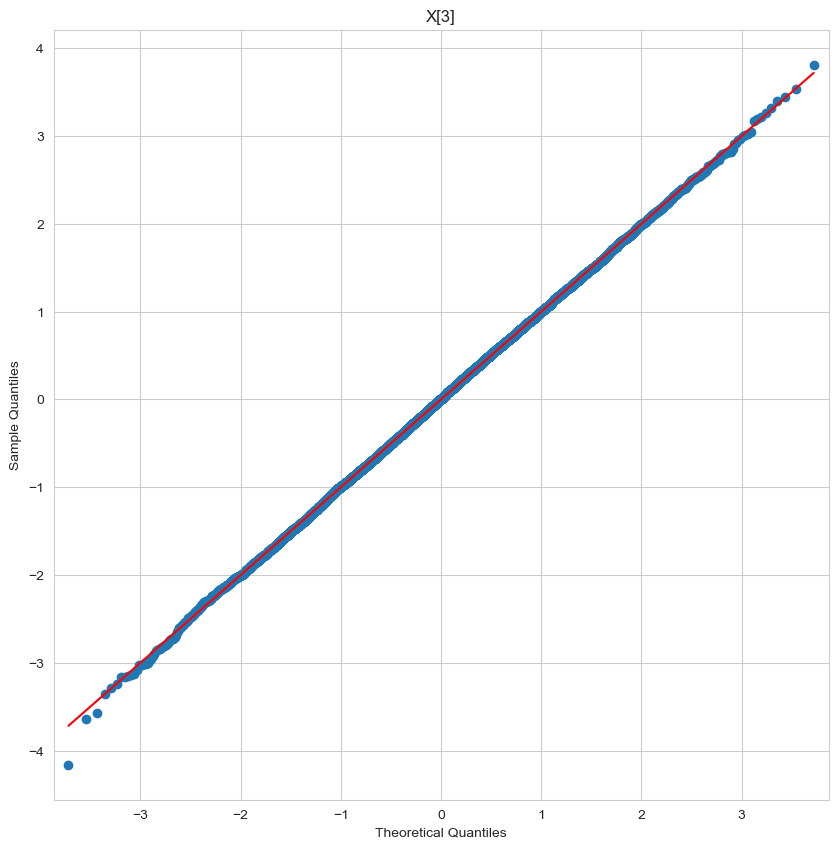

The data is normally distributed.
-------------------------------------
Q-Q plots and D’Agostino and Pearson’s test both agree, the Xs are normally distributed


In [258]:
# confirm that the Xs are normally distributed
for i in range(2):
    for j in range(2):
        sm.qqplot(new_dset[f'X{i*2+j}'],fit=True,line='s') # make QQ plot using sm package
        plt.title(f'X[{i*2+j}]')
        plt.show()
        stat, p = normaltest(new_dset[f'X{i*2+j}']) # use the D’Agostino and Pearson’s test for normality
        if p > 0.05:
            print("The data is normally distributed.")
        else:
            print("The data is not normally distributed.")
        print('-------------------------------------')
print("Q-Q plots and D’Agostino and Pearson’s test both agree, the Xs are normally distributed")

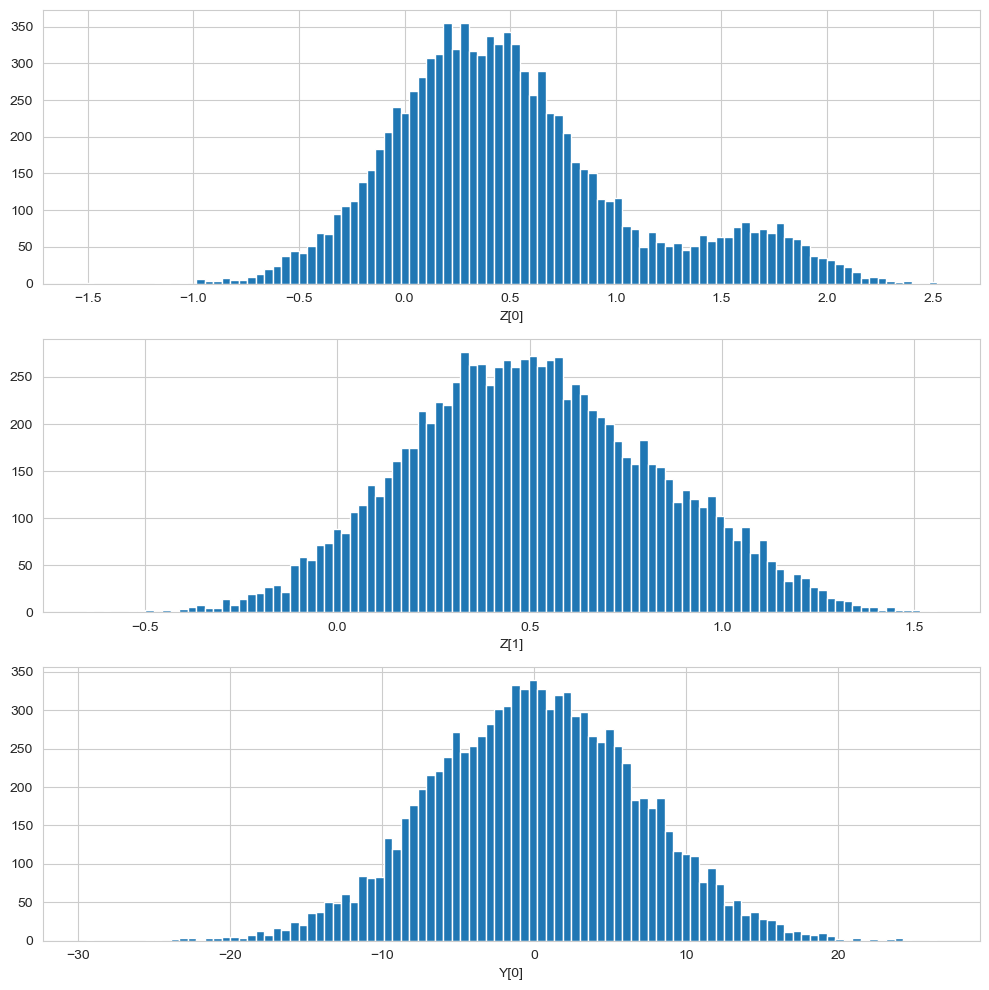

Looks liks Z[0] is bimodal, Z[1] looks a bit broad and may not be a gaussian either. Y[0] looks approximately normal


In [259]:
# now, look at the feature against Z
fig, axs = plt.subplots(3, 1, )

for i in range(2):
        axs[i].hist(new_dset[f'Z{i}'],bins=100) 
        axs[i].set_xlabel(f'Z[{i}]')
axs[2].hist(new_dset[f'Y0'],bins=100) 
axs[2].set_xlabel(f'Y[0]')
plt.tight_layout()
plt.show()
print('Looks liks Z[0] is bimodal, Z[1] looks a bit broad and may not be a gaussian either. Y[0] looks approximately normal')

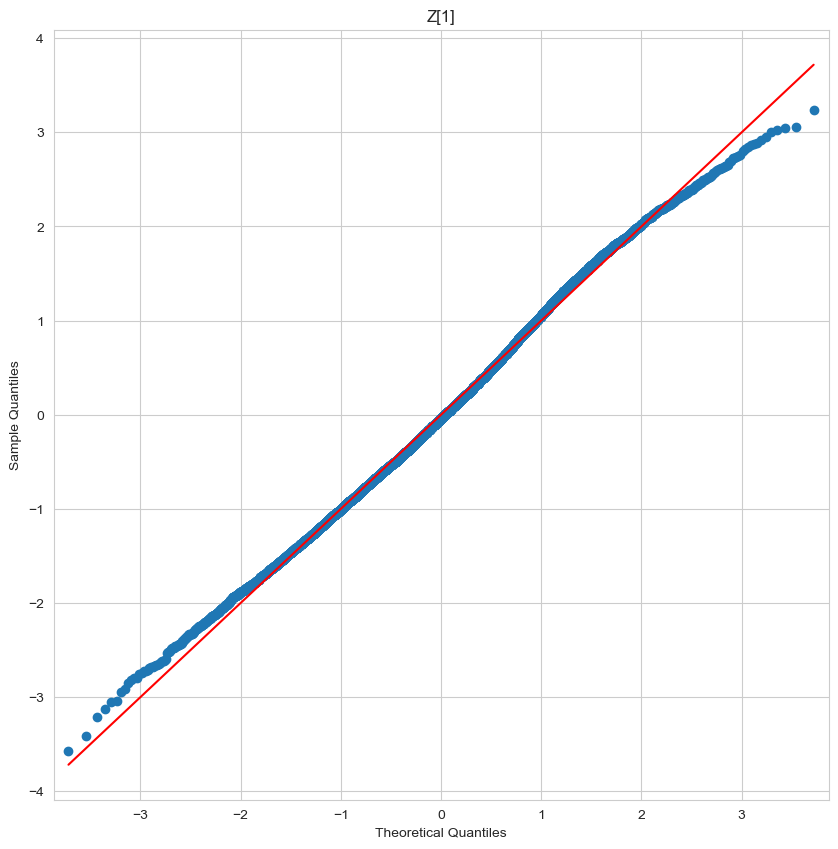

The data is not normally distributed.
Stats for normal test of Z[1]: 64.22154813140705, p=1.1336213422826751e-14
-------------------------------------


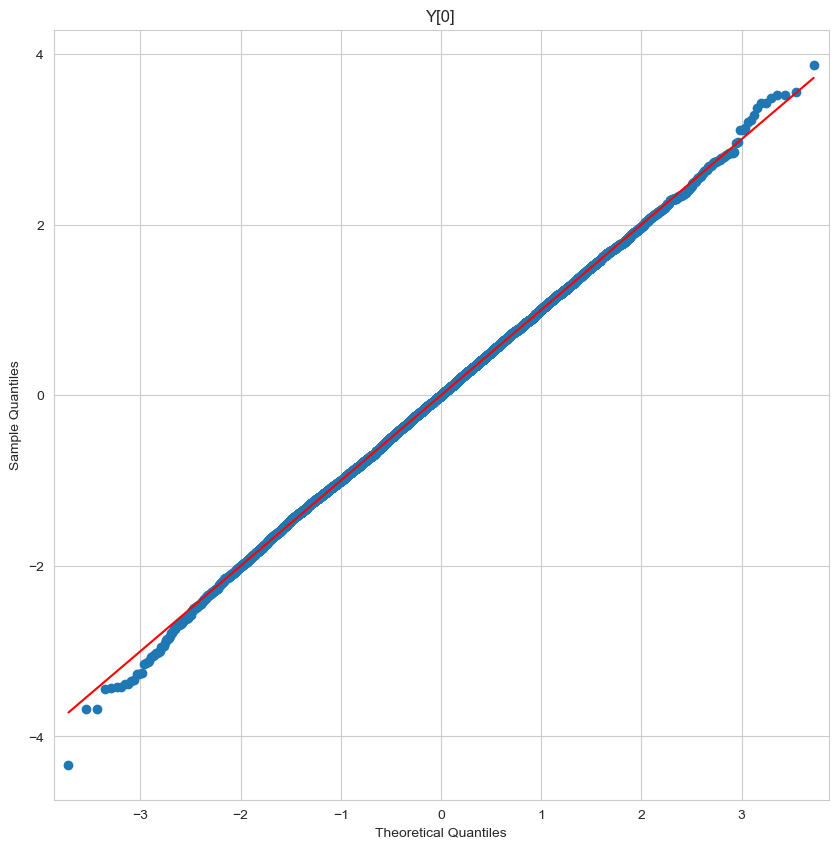

The data is normally distributed.
Stats for normal test of Y[0]: 2.8576488803212414, p=0.2395904096221615
-------------------------------------
So the Zs are not normally distributed.


In [260]:
# check if the Zs and Y are normally distributed. No need to check Z[0] since it is obviously not gaussian
sm.qqplot(new_dset[f'Z{1}'],fit=True,line='s')
plt.title(f'Z[{1}]')
plt.show()
stat, p = normaltest(new_dset[f'Z{1}'])
if p > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")
print(f'Stats for normal test of Z[1]: {stat}, p={p}')
print('-------------------------------------')

sm.qqplot(new_dset[f'Y{0}'],fit=True,line='s')
plt.title(f'Y[{0}]')
plt.show()
stat, p = normaltest(new_dset[f'Y{0}'])
if p > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")
print(f'Stats for normal test of Y[0]: {stat}, p={p}')
print('-------------------------------------')



print("So the Zs are not normally distributed.")

# Takeaways

- Data initially contained outliers in X. They can be removed by substituting with nans first and then removing the nans.
- There are some linear correlations between Y and X. Y and Z seem weakly correlated.
- The cross terms between X and Z contain additional information that can be useful in making predictions.
- The Xs are normally distributed. Zs are not (Z0 is bimodal, Z1 has broader tails). Y is normally distributed too.
- After removing the outliers and nans, the dataset contains 9983 elements.

----------------------------------------

# Step 2 - Propose a forecasting model for Y only using the variables in X without Z and explain its properties.

Given that X and Y are linearly related (as provided in the definition of the problem $ \vec{Y} = \mathbf{X} \cdot \vec{\beta} + \vec{\epsilon}$), using linear regression could offer a good tradeoff in terms of prediction accuracy, training speed, computational efficiency, interpretability and generalizability. 

In [262]:
# before starting, check that the features are not too correlated with one another
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
Xs = new_dset[['X0', 'X1', 'X2', 'X3']]
vif = pd.DataFrame()

vif["Variable"] = Xs.columns
vif["VIF"] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])] # get the VIF associated with the features


print(vif)
print('The Variance Inflation Factor is ~2.5 or less. This should be ok to use as is')

  Variable       VIF
0       X0  2.032553
1       X1  1.449250
2       X2  1.876605
3       X3  2.510140
The Variance Inflation Factor is ~2.5 or less. This should be ok to use as is


Mean Squared Error: 29.17984418468283
If you always predict the average, the mse is: 45.32045563162936, so the model is doing much better
R-squared: 0.3559000802533292
linear model parameters:
 const    0.090324
X0      -1.584985
X1       0.074356
X2      -1.497354
X3      -0.093074
dtype: float64
Ideally the tests and predictions fall in a straight line


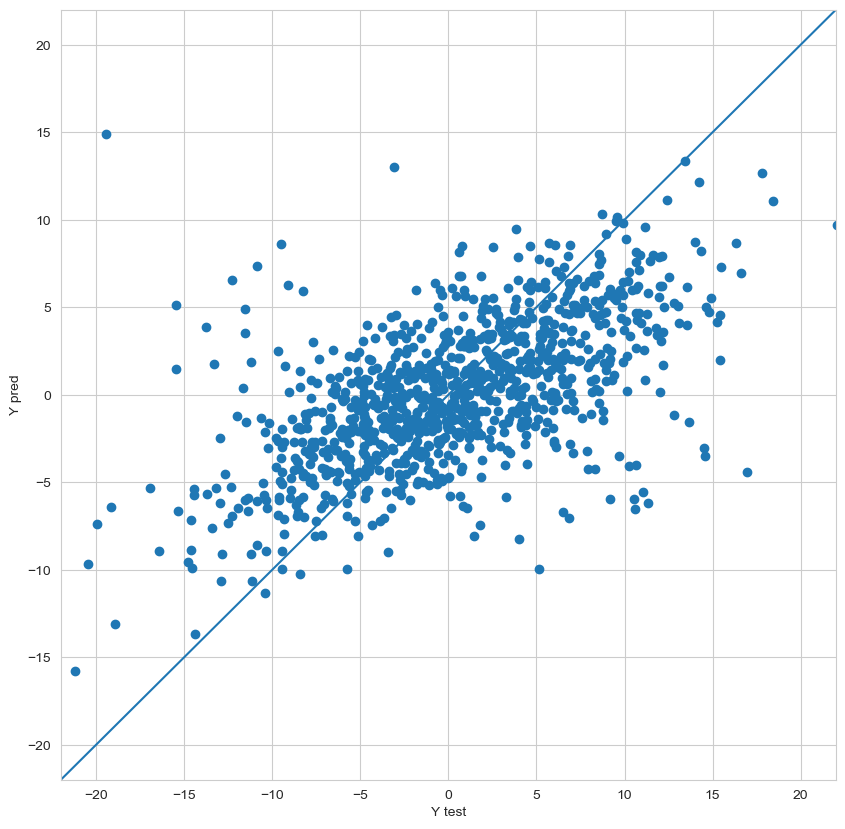

In [273]:
test_size = 0.1
Xs = new_dset[['X0', 'X1', 'X2', 'X3']]  # Predictor variables
Xs = sm.add_constant(Xs) # add constant for intercept
ys = new_dset['Y0']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=test_size, random_state=1)

# Train the linear regression model
linear_model = sm.OLS(y_train,X_train).fit()


# Predictions
y_pred = linear_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

simple_OLS_params = linear_model.params

print(f"Mean Squared Error: {mse}")
print(f'If you always predict the average, the mse is: {mean_squared_error( y_test, np.average(y_train)*np.ones_like(y_test) )}, so the model is doing much better')
print(f"R-squared: {r2}")


# Coefficients
print('linear model parameters:\n',simple_OLS_params)

# the large number of parameters make it hard to visualize the data. To 
print('Ideally the tests and predictions fall in a straight line')
plt.scatter(y_test, y_pred)
plt.plot([-22,22],[-22,22])
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.xlim(-22,22)
plt.ylim(-22,22)
plt.show()

In [274]:
# function to use the linear regression model to compute the prediction
# takes a dataframe with the Xs
def predict_linear_model(df):
    ys = np.dot(df,simple_OLS_params) 
    return ys

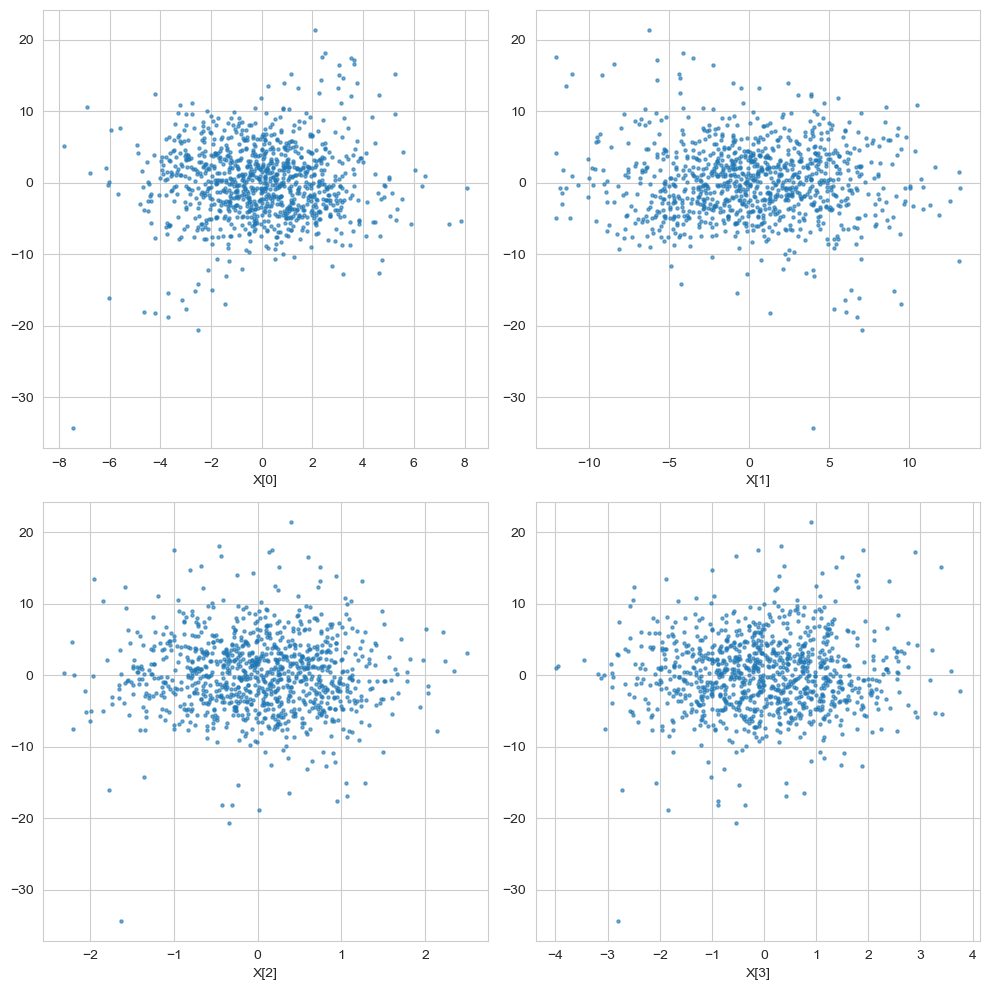

Looks like the residuals are mostly found in a horizontal band around 0, indication of an appropriate fit. There are some patterns to be seen in the deviations found in the plot for X[0], and less in X[1], where some residuals are ~ following a diagonal, indicating that there are some dynamics not captured by the simple model.


In [275]:
# evaluate quality of linear model: plot residuals against variables
fig, axs = plt.subplots(2, 2, )
residuals_linear_model = y_test - predict_linear_model(X_test)
for i in range(2):
    for j in range(2):
        axs[i,j].scatter(X_test[f'X{i*2+j}'],residuals_linear_model,s=5,alpha=0.6) 
        axs[i,j].set_xlabel(f'X[{i*2+j}]')
plt.tight_layout()
plt.show()
print('Looks like the residuals are mostly found in a horizontal band around 0, indication of an appropriate fit. There are some patterns to be seen in the deviations found in the plot for X[0], and less in X[1], where some residuals are ~ following a diagonal, indicating that there are some dynamics not captured by the simple model.')

Have a look at the cross terms, of the form X[i]*X[j]


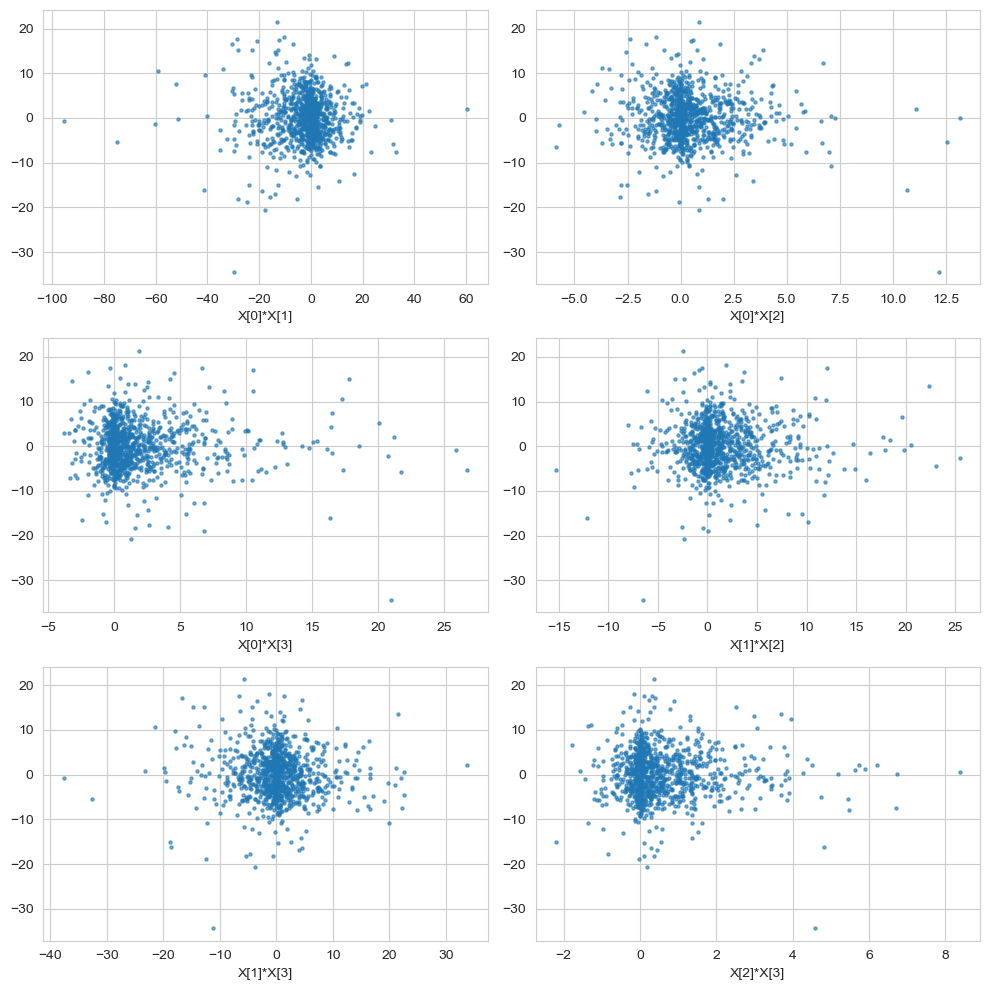

In [276]:
print('Have a look at the cross terms, of the form X[i]*X[j]')
from itertools import combinations
fig, axs = plt.subplots(3, 2, )
indices = [0,1,2,3]
combs = list(combinations(indices,2))
for i,comb in enumerate(combs):
    plot_x = X_test[f'X{comb[0]}'].to_numpy()*X_test[f'X{comb[1]}'].to_numpy()
    axs[i//2,i%2].scatter(plot_x,residuals_linear_model,s=5,alpha=0.6) 
    axs[i//2,i%2].set_xlabel(f'X[{comb[0]}]*X[{comb[1]}]')
    # print(i//2,i%2,comb)
plt.tight_layout()
plt.show()

In [277]:
#take a look at the confidence intervals and statistics of the fit

# Confidence intervals
confidence_intervals = linear_model.conf_int(alpha=0.05)  # 95% confidence intervals
print('parameters for the OLS:\n',linear_model.params)
print('-------------')
print('confidence intervals of the parameters (alpha=0.05):\n',confidence_intervals)
print('-------------')
print(linear_model.summary())
print('Given the low |t| for the intercept and X3, it is quite possible those that removing those variables could lighten the model with minimal effect on the accuracy.')

parameters for the OLS:
 const    0.090324
X0      -1.584985
X1       0.074356
X2      -1.497354
X3      -0.093074
dtype: float64
-------------
confidence intervals of the parameters (alpha=0.05):
               0         1
const -0.020642  0.201289
X0    -1.653280 -1.516689
X1     0.044532  0.104180
X2    -1.687210 -1.307498
X3    -0.232131  0.045983
-------------
                            OLS Regression Results                            
Dep. Variable:                     Y0   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     1409.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:12:35   Log-Likelihood:                -27835.
No. Observations:                8984   AIC:                         5.568e+04
Df Residuals:                    8979   BIC:                         5.572e+04


In [278]:
# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xs[['X0','X1','X2']], ys, test_size=test_size, random_state=42)

# Train the linear regression model
linear_model_v2 = sm.OLS(y_train2,X_train2).fit()
print(linear_model_v2.summary())

# Evaluation
y_pred2 = linear_model_v2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)

print(f"Mean Squared Error: {mse2}")
print(f"R-squared: {r22}")
print('As it can be seen, the model is only weakly affected by the removal of the intercept and X3 parameters.')

                                 OLS Regression Results                                
Dep. Variable:                     Y0   R-squared (uncentered):                   0.384
Model:                            OLS   Adj. R-squared (uncentered):              0.384
Method:                 Least Squares   F-statistic:                              1865.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        19:12:44   Log-Likelihood:                         -27836.
No. Observations:                8984   AIC:                                  5.568e+04
Df Residuals:                    8981   BIC:                                  5.570e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

----------------------------------------

# Step 3 - Further improve the modeling from (2) with both X and Z.

We can improve the model by including the Zs, as well as cross terms of the kind $X_{i}*Z_{j}$ to increase the accuracy of predictions

In [279]:
test_size = 0.1
dataset_XZ_prediction = new_dset.copy()
dataset_XZ_prediction['X0*Z0']=dataset_XZ_prediction['X0']*dataset_XZ_prediction['Z0']
dataset_XZ_prediction['X0*Z1']=dataset_XZ_prediction['X0']*dataset_XZ_prediction['Z1']
dataset_XZ_prediction['X1*Z0']=dataset_XZ_prediction['X1']*dataset_XZ_prediction['Z0']
dataset_XZ_prediction['X1*Z1']=dataset_XZ_prediction['X1']*dataset_XZ_prediction['Z1']
dataset_XZ_prediction['X2*Z0']=dataset_XZ_prediction['X2']*dataset_XZ_prediction['Z0']
dataset_XZ_prediction['X2*Z1']=dataset_XZ_prediction['X2']*dataset_XZ_prediction['Z1']
dataset_XZ_prediction['X3*Z0']=dataset_XZ_prediction['X3']*dataset_XZ_prediction['Z0']
dataset_XZ_prediction['X3*Z1']=dataset_XZ_prediction['X3']*dataset_XZ_prediction['Z1']

Xs = dataset_XZ_prediction[['X0', 'X1', 'X2', 'X3','Z0','Z1','X0*Z0','X1*Z0','X2*Z0','X3*Z0','X0*Z1','X1*Z1','X2*Z1','X3*Z1']]

# Compute VIF for each feature
vif2 = pd.DataFrame()
vif2["Variable"] = Xs.columns
vif2["VIF"] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])]

print(vif2)
print('The addition of the cross terms has increased the VIF in a not insignificant amount. It would make sense to use PCA here to reduce some of the colinearity between terms. Let us look at how the models performs as is first to see if any terms are redundant.')


Xs= sm.add_constant(Xs)
ys =  dataset_XZ_prediction['Y0']

   Variable        VIF
0        X0   7.273871
1        X1   5.092715
2        X2   6.695350
3        X3   8.880998
4        Z0   1.991283
5        Z1   1.992405
6     X0*Z0   4.131907
7     X1*Z0   3.009309
8     X2*Z0   3.867041
9     X3*Z0   5.350008
10    X0*Z1   8.149385
11    X1*Z1   5.707213
12    X2*Z1   7.604235
13    X3*Z1  10.512860
The addition of the cross terms has increased the VIF in a not insignificant amount. It would make sense to use PCA here to reduce some of the colinearity between terms. Let us look at how the models performs as is first to see if any terms are redundant.


Mean Squared Error: 22.51461214236236
R-squared: 0.5150351329917173
linear model parameters:
 const    0.082251
X0      -2.794661
X1       0.340976
X2      -1.688193
X3       0.159813
Z0       0.042352
Z1      -0.078345
X0*Z0    1.177209
X1*Z0   -0.339537
X2*Z0    0.300136
X3*Z0   -0.017606
X0*Z1    1.205768
X1*Z1   -0.215960
X2*Z1    0.060617
X3*Z1   -0.463792
dtype: float64


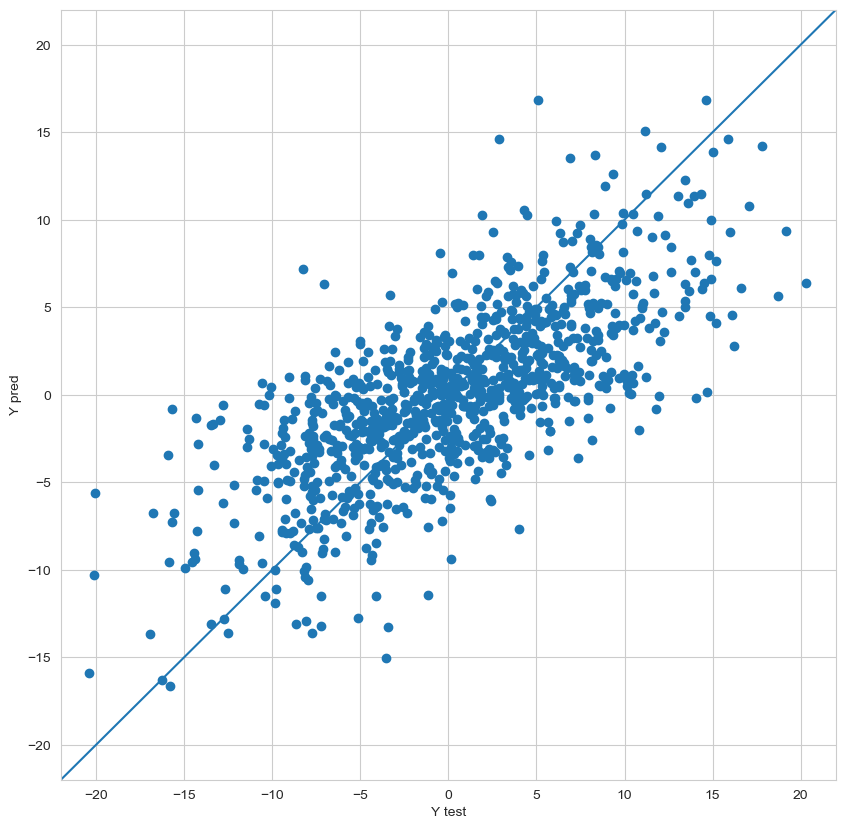

In [281]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=test_size, random_state=42)

# Train the linear regression model
linear_model_XZ = sm.OLS(y_train,X_train).fit()

# Predictions
y_pred = linear_model_XZ.predict(X_test)
summary_frame = linear_model_XZ.get_prediction(X_test).summary_frame(alpha=0.05)# 95% confidence interval
ci_lower = summary_frame['mean_ci_lower']
ci_upper = summary_frame['mean_ci_upper']

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Coefficients
print('linear model parameters:\n',linear_model_XZ.params)

plt.scatter(y_test, y_pred)
plt.plot([-22,22],[-22,22])
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.xlim(-22,22)
plt.ylim(-22,22)
plt.show()

Using a linear regression with X and Z, including the cross terms, helped a lot in terms of increasing the accuracy.

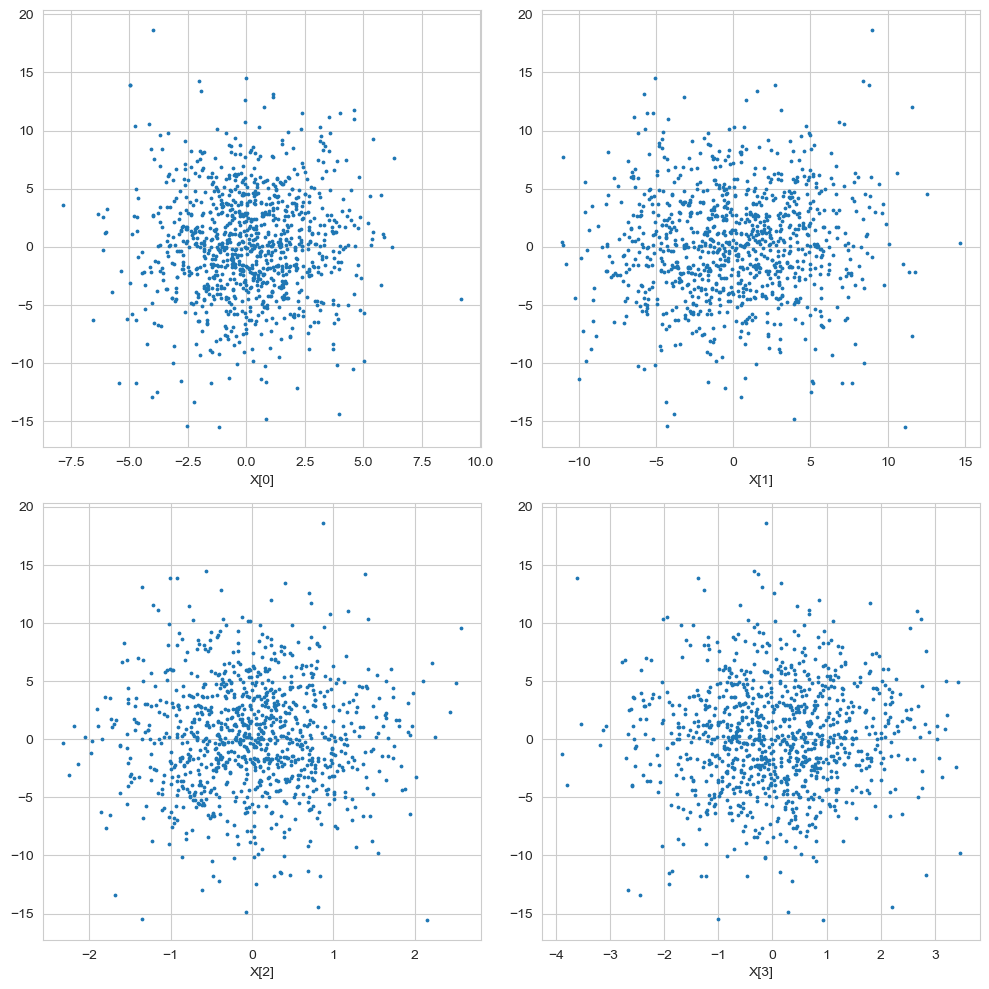

Now, the residuals look a lot more scattered, with no obvious patterns present.


In [282]:
# evaluate quality of linear model: plot residuals against variables
fig, axs = plt.subplots(2, 2, )
residuals_linear_XZ_model = y_test - linear_model_XZ.predict(X_test)
for i in range(2):
    for j in range(2):
        axs[i,j].scatter(X_test[f'X{i*2+j}'],residuals_linear_XZ_model,s=3,alpha=1) 
        axs[i,j].set_xlabel(f'X[{i*2+j}]')
plt.tight_layout()
plt.show()
print('Now, the residuals look a lot more scattered, with no obvious patterns present.')

In [283]:
#take a look at the confidence intervals and statistics of the fit

# Confidence intervals
confidence_intervals = linear_model_XZ.conf_int(alpha=0.05)  # 95% confidence intervals
print('parameters for the OLS:\n',linear_model_XZ.params)
print('-------------')
print('confidence intervals of the parameters (alpha=0.05):\n',confidence_intervals)
print('-------------')
print(linear_model_XZ.summary())
print('Given the low |t| for the intercept, X3, Z0, Z1, X3*Z0, X2*Z1, the model could be simplified by removing those parameters from the dependent variables with minimal impact on the performance of the movel. We can see how a model after dropping those parameters performs.')


parameters for the OLS:
 const    0.082251
X0      -2.794661
X1       0.340976
X2      -1.688193
X3       0.159813
Z0       0.042352
Z1      -0.078345
X0*Z0    1.177209
X1*Z0   -0.339537
X2*Z0    0.300136
X3*Z0   -0.017606
X0*Z1    1.205768
X1*Z1   -0.215960
X2*Z1    0.060617
X3*Z1   -0.463792
dtype: float64
-------------
confidence intervals of the parameters (alpha=0.05):
               0         1
const -0.099934  0.264436
X0    -2.907200 -2.682123
X1     0.292341  0.389612
X2    -2.002421 -1.373965
X3    -0.068099  0.387724
Z0    -0.136551  0.221255
Z1    -0.400774  0.244084
X0*Z0  1.067225  1.287193
X1*Z0 -0.386463 -0.292610
X2*Z0 -0.011490  0.611762
X3*Z0 -0.241950  0.206738
X0*Z1  1.006795  1.404741
X1*Z1 -0.301074 -0.130847
X2*Z1 -0.497719  0.618952
X3*Z1 -0.876366 -0.051218
-------------
                            OLS Regression Results                            
Dep. Variable:                     Y0   R-squared:                       0.529
Model:                            

In [285]:
# Compute VIF for each feature
Xs_after_dropping = Xs.drop(['const','X3','Z0','Z1','X3*Z0','X2*Z1'], axis=1)
vif3 = pd.DataFrame()
vif3["Variable"] = Xs_after_dropping.columns
vif3["VIF"] = [variance_inflation_factor(Xs_after_dropping.values, i) for i in range(Xs_after_dropping.shape[1])]

print(vif3)
print('There are still some components with fairly high VIF. To improve, let us apply PCA to the dataset.')

  Variable       VIF
0       X0  4.299546
1       X1  4.489492
2       X2  2.592089
3    X0*Z0  2.537460
4    X1*Z0  2.927692
5    X2*Z0  2.523879
6    X0*Z1  5.530730
7    X1*Z1  4.423647
8    X3*Z1  2.291247
There are still some components with fairly high VIF. To improve, let us apply PCA to the dataset.


In [286]:
from sklearn.decomposition import PCA

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xs_after_dropping, ys, test_size=test_size, random_state=1) # create train and test dataset

scaler = StandardScaler() # standard scaler to standardize the features
standardized_Xs_after_dropping = scaler.fit_transform(X_train2) # fit the scaler on the training variables
standardized_Xs_test_after_dropping = scaler.transform(X_test2) # apply the scaling to the test


pca = PCA(.99) #99% of the variance
pca.fit(standardized_Xs_after_dropping) # fit the pca


X_train2 = pd.DataFrame(pca.transform(standardized_Xs_after_dropping)) # create the train dataset
X_test2 = pd.DataFrame(pca.transform(standardized_Xs_test_after_dropping)) # create the test dataset

vif4 = pd.DataFrame() # check vif
vif4["VIF"] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]

print(vif4)


   VIF
0  1.0
1  1.0
2  1.0
3  1.0
4  1.0
5  1.0
6  1.0
7  1.0


In [287]:
# Train-test split
# X_train2, X_test2, y_train2, y_test2 = train_test_split(transformed_X, ys, test_size=test_size, random_state=1)

print(y_train2.shape,X_train2.shape)

# Train the linear regression model
linear_model_XZ_v2 = sm.OLS( list(y_train2),X_train2).fit()
print(linear_model_XZ_v2.summary())

# Evaluation
y_pred2_XZ = linear_model_XZ_v2.predict(X_test2)
mse2_XZ = mean_squared_error(y_test2, y_pred2_XZ)
r22_XZ = r2_score(y_test2, y_pred2_XZ)

print(f"Mean Squared Error: {mse2_XZ}, as compared to the model which was done on the entire dataset:{mse}")
print(f"R-squared: {r22_XZ}")
print('As it can be seen, the model is only weakly affected by the removal of those parameters.')

(8984,) (8984, 8)
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.517
Model:                            OLS   Adj. R-squared (uncentered):              0.516
Method:                 Least Squares   F-statistic:                              1199.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        19:18:40   Log-Likelihood:                         -26758.
No. Observations:                8984   AIC:                                  5.353e+04
Df Residuals:                    8976   BIC:                                  5.359e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

-------------

#### Try Using XGB on all the features available

In [288]:
# Option 2: Train XGB on all the features together
features = new_dset[['X0','X1','X2','X3','Z0','Z1']]
ys = new_dset['Y0']
features_train, features_test, y_train, y_test = train_test_split(features, ys, test_size=test_size, random_state=42)

# Use optuna to identify good range of parameters for XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        # 'tree_method': 'gpu_hist',
        # 'predictor': 'gpu_predictor'
    }

    model = XGBRegressor(**params)
    model.fit(features_train, y_train, eval_set=[(features_test, y_test)],verbose=False)#, early_stopping_rounds=200, verbose=False)
    preds = model.predict(features_test) 
    return mean_squared_error(y_test, preds)
print('Use optuna to identify good range of parameters for XGBoost......')
study_xgb_all_features = optuna.create_study(direction='minimize')
study_xgb_all_features.optimize(objective_xgb, n_trials=50)
print("Best parameters for XGBoost:", study_xgb_all_features.best_params)

[I 2025-01-09 19:20:27,787] A new study created in memory with name: no-name-2198fe97-5e04-480b-9f26-5b7a6e0c7e4d


Use optuna to identify good range of parameters for XGBoost......


[I 2025-01-09 19:20:34,027] Trial 0 finished with value: 24.09073747638761 and parameters: {'n_estimators': 2144, 'learning_rate': 0.09333263102484919, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7482739214089535, 'colsample_bytree': 0.7934428703255461, 'reg_alpha': 8.060957832190311, 'reg_lambda': 2.1569488802011465}. Best is trial 0 with value: 24.09073747638761.
[I 2025-01-09 19:20:37,639] Trial 1 finished with value: 23.557754128398983 and parameters: {'n_estimators': 2205, 'learning_rate': 0.05907396987496139, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5439324649995023, 'colsample_bytree': 0.9179141621273827, 'reg_alpha': 1.9602123528562907, 'reg_lambda': 1.7797256612111176}. Best is trial 1 with value: 23.557754128398983.
[I 2025-01-09 19:20:45,317] Trial 2 finished with value: 22.903704028598415 and parameters: {'n_estimators': 2695, 'learning_rate': 0.020950953828060958, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.542578171986666, 'colsample_bytr

Best parameters for XGBoost: {'n_estimators': 305, 'learning_rate': 0.04387433614652041, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7612747706894026, 'colsample_bytree': 0.931759691683737, 'reg_alpha': 5.548264399051695, 'reg_lambda': 8.27885083342225}


In [289]:
# look at the best parameters
study_xgb_all_features.best_params

{'n_estimators': 305,
 'learning_rate': 0.04387433614652041,
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 0.7612747706894026,
 'colsample_bytree': 0.931759691683737,
 'reg_alpha': 5.548264399051695,
 'reg_lambda': 8.27885083342225}

In [290]:
# Create the model with the best parameters
best_params_all_features = study_xgb_all_features.best_params
final_model_all_features = XGBRegressor(**best_params_all_features, )

# Fit the final model
final_model_all_features.fit(features_train, y_train)

# Make predictions
final_predictions_all_features = final_model_all_features.predict(features_test)

# Calculate MSE
mse_final_all_features = mean_squared_error(y_test, final_predictions_all_features)
print(f"Final MSE using all the features: {mse_final_all_features:.3f}")

Final MSE using all the features: 19.724


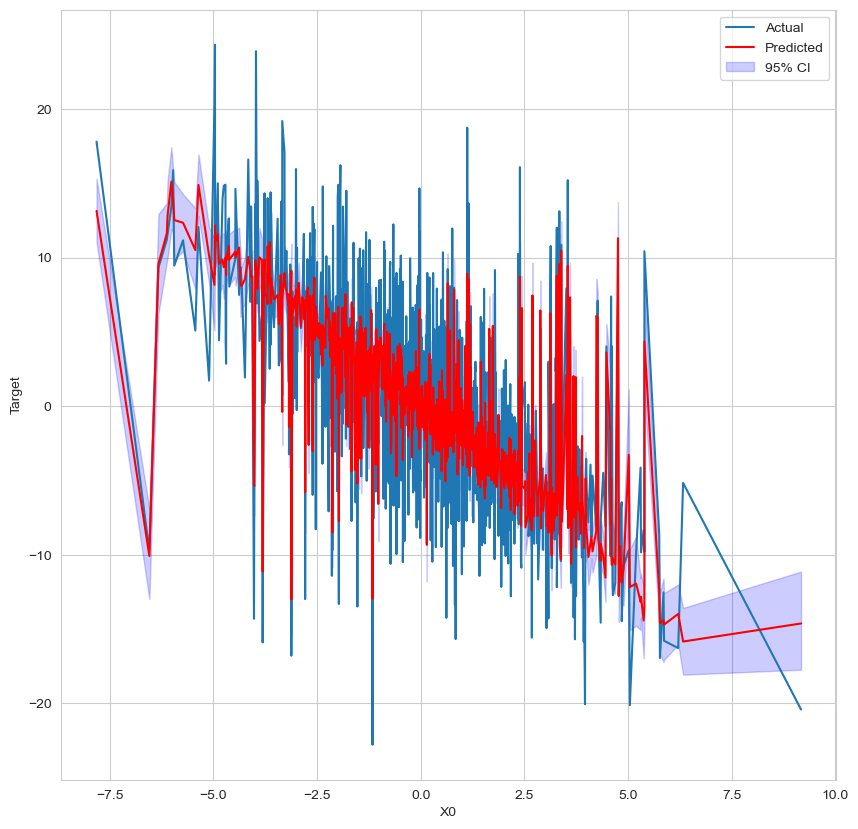

In [291]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 500
predictions = []
errors = []
for _ in range(n_bootstraps):
    # Resample the data
    X_resampled, y_resampled = resample(X_train, y_train)
    
    # Fit the model
    model = XGBRegressor(**best_params_all_features)
    model.fit(X_resampled, y_resampled)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    errors.append(mean_squared_error(y_test, y_pred))

# Convert to numpy array for easier manipulation
predictions = np.array(predictions)

# Calculate the mean prediction and confidence intervals
mean_prediction = predictions.mean(axis=0)

ci_lower = np.percentile(predictions, 2.5, axis=0)
ci_upper = np.percentile(predictions, 97.5, axis=0)

# Plot the predictions and confidence intervals

####
# Combine all the relevant data into a single DataFrame for sorting
# Sort by var
var_of_interst = 'X0'
data_to_plot = pd.DataFrame({
    var_of_interst: X_test[var_of_interst],
    'y_test': y_test,
    'y_pred': mean_prediction,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})


data_sorted = data_to_plot.sort_values(by=var_of_interst)

# Extract the sorted columns
X_test_sorted = data_sorted[var_of_interst]
y_test_sorted = data_sorted['y_test']
y_pred_sorted = data_sorted['y_pred']
ci_lower_sorted = data_sorted['ci_lower']
ci_upper_sorted = data_sorted['ci_upper']

# Plot the sorted data
plt.plot(X_test_sorted, y_test_sorted, label='Actual')
plt.plot(X_test_sorted, y_pred_sorted, label='Predicted', color='red')
plt.fill_between(X_test_sorted, ci_lower_sorted, ci_upper_sorted, color='blue', alpha=0.2, label='95% CI')
plt.xlabel(var_of_interst)
plt.ylabel('Target')
plt.legend()
plt.show()
####


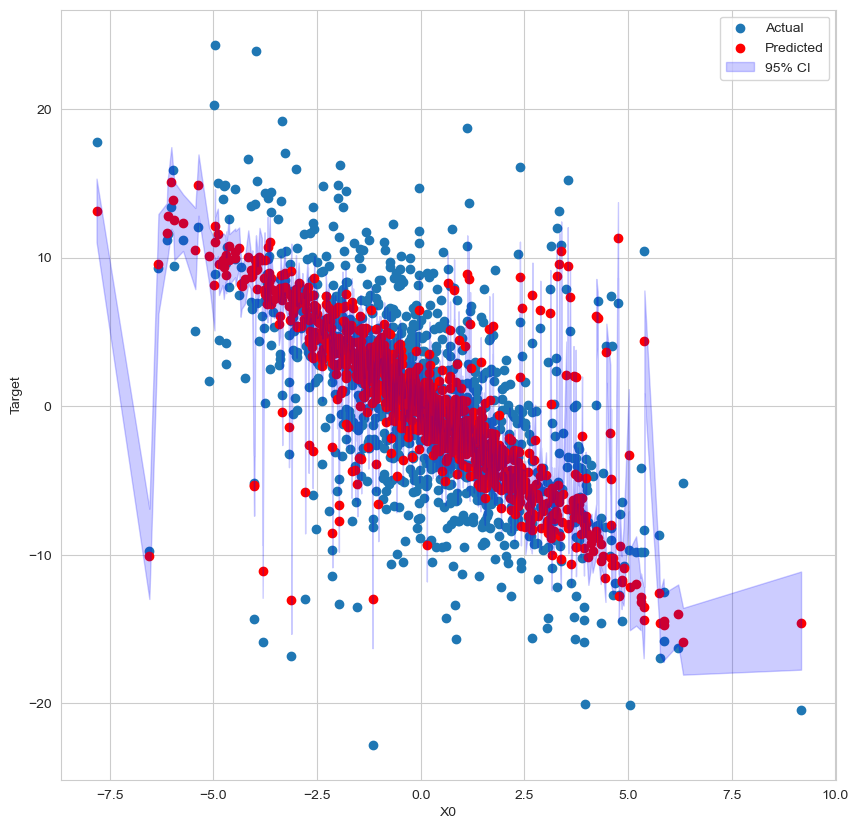

In [295]:
# Plot as a scatter plot, different visualization
plt.scatter(X_test_sorted, y_test_sorted, label='Actual')
plt.scatter(X_test_sorted, y_pred_sorted, label='Predicted', color='red')
plt.fill_between(X_test_sorted, ci_lower_sorted, ci_upper_sorted, color='blue', alpha=0.2, label='95% CI')
plt.xlabel(var_of_interst)
plt.ylabel('Target')
plt.legend()
plt.show()
####

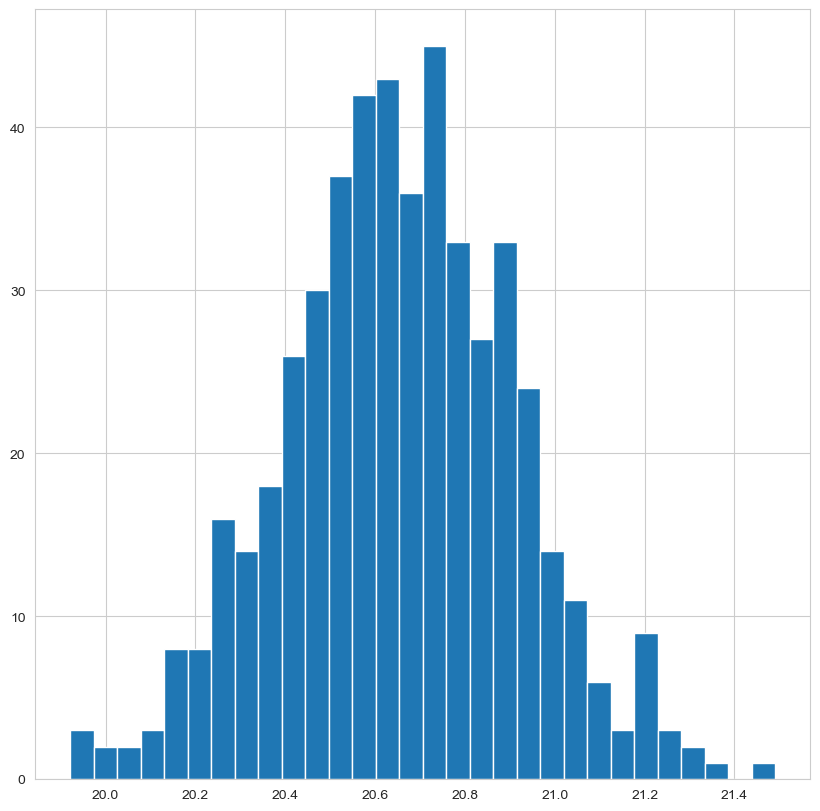

average of the mean squared error from bootstrapping: 20.65453405573789
19.921841392327906


In [296]:
plt.hist(errors,bins=30)
plt.show()
print('average of the mean squared error from bootstrapping:',np.average(errors))
print(np.min(errors))

---------------------

# 4: Evaluate the quality of your models and of their parameter estimates. Which one produces the best forecast? Interpret why

- The simple linear model using only Xs (first model, built in part 2) can predict Y fairly well, but it is clear the residuals against the features that this simple model cannot capture. Evaluation on a subset of the data (15%), gives roughly a mean squared error of 29.1
- Adding the features of Z, as well as cross terms between X and Z significantly improves performance of the model, which could achieve a mean squared error of ~ 22.3. The improved performance of this model is primarily caused by the inclusion of the cross terms, as compared to the predictive power of the Z variables isolated, which are lightly correlated with Y.
- A even more performing model was developed by using XGBoost to train on all the features (Xs and Zs). The model was able to capture higher order interactions in the data and push down the mean squared error to ~ 20, averaged with bootstrapping.

#### If you always blindly predict the average, your mse error would be on the order of

In [297]:
mse_basic_average = mean_squared_error(y_test, np.average(y_train)*np.ones_like(y_test))
print(f'The MSE from predicting the simple average is:{mse_basic_average:.3f}')

The MSE from predicting the simple average is:46.442


The quality of the parameters of the first models are described in the summary of the OLS fitter

### First model, just using X

In [298]:
print(linear_model_v2.summary())
print('We can see that the coefficients for the Xs have fairly low standard errors, and that their t statistics is highly significant.')
print(f'The mean squared error for the linear model is:{mse2}')

                                 OLS Regression Results                                
Dep. Variable:                     Y0   R-squared (uncentered):                   0.384
Model:                            OLS   Adj. R-squared (uncentered):              0.384
Method:                 Least Squares   F-statistic:                              1865.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        19:32:21   Log-Likelihood:                         -27836.
No. Observations:                8984   AIC:                                  5.568e+04
Df Residuals:                    8981   BIC:                                  5.570e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Second Model, OLS of X and Z (including cross terms)

In [299]:
print(linear_model_XZ_v2.summary())
print(f'As for the model which includes the Zs, the performance achieved is {mse2_XZ}')

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.517
Model:                            OLS   Adj. R-squared (uncentered):              0.516
Method:                 Least Squares   F-statistic:                              1199.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        19:32:29   Log-Likelihood:                         -26758.
No. Observations:                8984   AIC:                                  5.353e+04
Df Residuals:                    8976   BIC:                                  5.359e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Third Model, XGBoost on all the features

In [300]:
print(f'The average of the mean squared error on the testing set based on bootstrapping is: {np.average(errors)}')

The average of the mean squared error on the testing set based on bootstrapping is: 20.65453405573789


##### To have a better understanding of XGB, we can investigate the study done with Optuna

In [301]:
# Optimization History:
fig = optuna.visualization.plot_optimization_history(study_xgb_all_features,)
fig.show()

In [302]:
# Parameter Importance:
fig = optuna.visualization.plot_param_importances(study_xgb_all_features,)
fig.show()

### Takeaways

- Using the features provided greatly improves the accuracy of the predictions on Y
- Simple linear regression using the features in X achieved a reasonably good performance at predicting Y (mse ~ 29). While Z on its own has little predictive power on Y, a linear regression model including the interaction of Z with X leads to major performance improvements (mse ~ 22). 
- By looking at the statistics of the fitting parameters, it was possible to remove various parameteres that have little to add to the predictive power of the model.
- A gradient boosted framework using the features on X and Y was able to capture even more complex dynamics than the linear regression models. It achieves slightly higher performance, at the cost of lower interpretability. 